# Carregar dados

In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = './ptb-xl/'
sampling_rate=100

Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

X = load_raw_data(Y, sampling_rate, path)

agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Mostar ECG

In [2]:
patient_ecg = X[0]

inverted_ecg = np.zeros((12,1000))

position = 0

for lead in patient_ecg:
    for index in range(12):
        inverted_ecg[index][position] = lead[index]
        
    position+=1

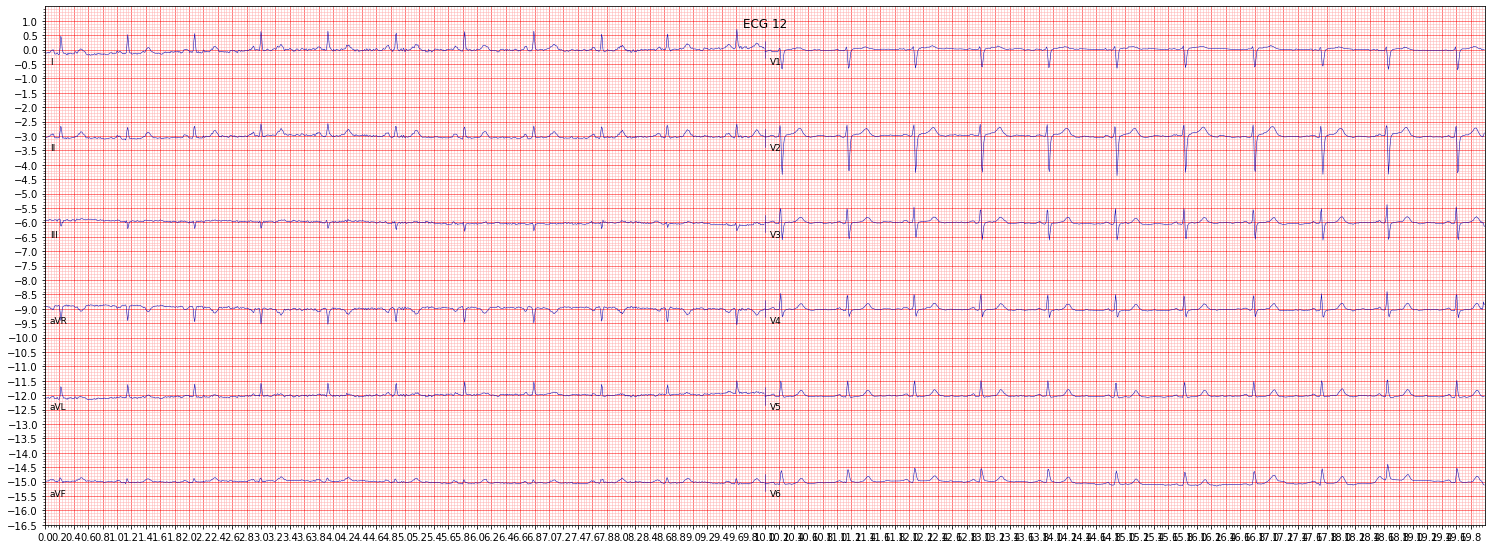

In [3]:
import ecg_plot

ecg_plot.plot(inverted_ecg, sample_rate = 100, title = 'ECG 12')
ecg_plot.show()

# Pré-processamento

In [2]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [3]:
super_class = []
for index, row in Y.iterrows():
    if len(row['diagnostic_superclass']) == 1 and 'NORM' in row['diagnostic_superclass']:
        super_class.append('NORM')
    elif 'MI' in row['diagnostic_superclass']:
        super_class.append('MI')
    else:
        super_class.append('out')

Y.diagnostic_superclass = super_class

In [4]:
test_fold = 10

a = Y.diagnostic_superclass=='NORM'
b = Y.diagnostic_superclass=='MI'

c = np.logical_or(a, b)

X_train_logical = np.logical_and(c,Y.strat_fold != test_fold)

Train_logical = np.logical_and(c,Y.strat_fold != test_fold)

Test_logical = np.logical_and(c,Y.strat_fold == test_fold)

In [5]:
X_train = X[np.where(Train_logical)]
y_train = Y[(Train_logical)].diagnostic_superclass
X_train_sex = Y[(Train_logical)].sex
X_train_age = Y[(Train_logical)].age

X_test = X[np.where(Test_logical)]
y_test = Y[Test_logical].diagnostic_superclass
X_test_sex = Y[Test_logical].sex
X_test_age = Y[Test_logical].age


In [6]:
def convert_class_to_number(Y):
    data = []
    for classification in Y:
        if 'NORM' in classification:
            data.append(0)
        elif 'MI' in classification:
            data.append(1)
    return data


In [7]:
y_train_num = convert_class_to_number(y_train)
y_test_num = convert_class_to_number(y_test)

In [8]:
X_train_reshape = np.reshape(X_train, (len(X_train), 1000*12))
X_test_reshape = np.reshape(X_test, (len(X_test), 1000*12))

In [9]:
X_train_sex_arr = np.array(X_train_sex.tolist())
X_train_age_arr = np.array(X_train_age.tolist())

X_test_sex_arr = np.array(X_test_sex.tolist())
X_test_age_arr = np.array(X_test_age.tolist())

In [10]:
X_train_sex_age = np.column_stack((X_train_sex_arr, X_train_age_arr))
X_test_sex_age =  np.column_stack((X_test_sex_arr, X_test_age_arr))

In [11]:
X_train_arr = np.column_stack((X_train_sex_age, X_train_reshape))
X_test_arr = np.column_stack((X_test_sex_age, X_test_reshape))

# Decision Tree GS

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [70]:
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,6,7],
    'max_leaf_nodes': [None, 1, 10, 30]
}

In [ ]:
param_grid = {
    'max_depth': [5, 10, 50, 100, 150],
    'min_samples_leaf': [1],
    'min_samples_split': [1,2],
    'max_leaf_nodes': [25,30,40]
}

In [71]:
rf = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)

In [72]:
grid_search = grid_search.fit(X_train_arr, y_train_num)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 20.2min finished


In [73]:
predict = grid_search.predict(X_test_arr)

In [74]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_test_num, predict)

0.7006151742993848

In [75]:
confusion_matrix(y_test_num, predict)

array([[719, 193],
       [245, 306]], dtype=int64)

In [76]:
grid_search.best_params_

{'max_depth': 10,
 'max_leaf_nodes': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [77]:
import joblib
joblib.dump(grid_search.best_estimator_, "./dt.joblib")

['./dt.joblib']

# Random Forest GS

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [15]:
param_grid = {
    'bootstrap': [False, True],
    'max_depth': [10, 20, 30, 40],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,6,7],
    'n_estimators': [200, 300, 1300, 1500],
    'max_leaf_nodes': [None, 1, 10, 30]
}

In [17]:
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)

In [18]:
grid_search = grid_search.fit(X_train_arr, y_train_num)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed: 15.0min remaining: 15.0min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 16.8min finished


In [19]:
predict = grid_search.predict(X_test_arr)

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_test_num, predict)

0.797676008202324

In [102]:
confusion_matrix(y_test_num, predict)

array([[858,  54],
       [244, 307]], dtype=int64)

In [103]:
grid_search.best_params_ 

{'bootstrap': False,
 'max_depth': 110,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 1300}

In [25]:
import joblib
joblib.dump(grid_search.best_estimator_, "./random_forest.joblib")

['./random_forest.joblib']

In [17]:
import joblib
loaded_rf = joblib.load("./models/random_forest.joblib")

# Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
params = {
    'bootstrap': False,
    'max_depth': 110,
    'min_samples_leaf': 1,
    'min_samples_split': 6,
    'n_estimators': 1300,
    'max_leaf_nodes': None
}

In [39]:
clf = RandomForestClassifier(
    bootstrap=params['bootstrap'],
    max_depth=params['max_depth'],
    min_samples_leaf=params['min_samples_leaf'],
    min_samples_split=params['min_samples_split'],
    n_estimators=params['n_estimators'],
    max_leaf_nodes=params['max_leaf_nodes'],
)
clf.fit(X_train_arr, y_train_num)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=1300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [85]:
from sklearn.metrics import accuracy_score, confusion_matrix

predict = clf.predict(X_test_arr)

acc = accuracy_score(y_test_num, predict)

print(f'{acc*100:.2f}')

80.38


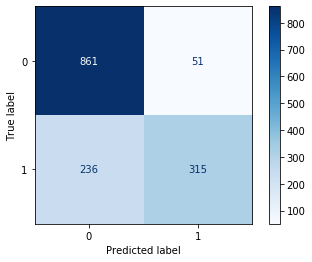

In [82]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_num, predict, labels=clf.classes_)

plot_confusion_matrix(
        clf,
        X=X_test_arr, 
        y_true=y_test_num,
        display_labels=[0,1],
        cmap=plt.cm.Blues,
        values_format='g'
    )

In [43]:
import joblib
joblib.dump(clf, "./random_forest_bom_bom.joblib")

['./random_forest_bom_bom_2.joblib']

In [28]:
import joblib
# loaded_rf = joblib.load("./random_forest.joblib")

# DT

In [88]:
from sklearn.tree import DecisionTreeClassifier

In [89]:
params = {
    'max_depth': 10,
    'max_leaf_nodes': 30,
    'min_samples_leaf': 1,
    'min_samples_split': 2
}

In [90]:
clf = DecisionTreeClassifier(
    max_depth=params['max_depth'],
    max_leaf_nodes=params['max_leaf_nodes'],
    min_samples_leaf=params['min_samples_leaf'],
    min_samples_split=params['min_samples_split']
)
clf.fit(X_train_arr, y_train_num)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=30,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [91]:
from sklearn.metrics import accuracy_score, confusion_matrix

predict = clf.predict(X_test_arr)

accuracy_score(y_test_num, predict)

0.7006151742993848

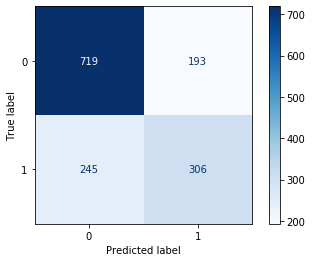

In [92]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_num, predict, labels=clf.classes_)

plot_confusion_matrix(
        clf,
        X=X_test_arr, 
        y_true=y_test_num,
        display_labels=[0,1],
        cmap=plt.cm.Blues,
        values_format='g'
    )

In [93]:
import joblib
joblib.dump(grid_search.best_estimator_, "./dt_bom_bom.joblib")

['./dt_bom_bom.joblib']

# Get Pacient

In [13]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [15]:
X_train_arr[0].astype(str)

array(['1.0', '56.0', '-0.119', '-0.055', '0.064', '0.086', '-0.091',
       '0.004', '-0.069', '-0.031', '0.0', '-0.026', '-0.039', '-0.079',
       '-0.116', '-0.051', '0.065', '0.083', '-0.09', '0.006', '-0.064',
       '-0.036', '-0.003', '-0.031', '-0.034', '-0.074', '-0.12',
       '-0.044', '0.076', '0.082', '-0.098', '0.016', '-0.058', '-0.034',
       '-0.01', '-0.028', '-0.029', '-0.069', '-0.117', '-0.038', '0.08',
       '0.077', '-0.098', '0.021', '-0.05', '-0.03', '-0.015', '-0.023',
       '-0.022', '-0.064', '-0.103', '-0.031', '0.072', '0.066', '-0.087',
       '0.021', '-0.045', '-0.027', '-0.02', '-0.019', '-0.018', '-0.058',
       '-0.097', '-0.025', '0.071', '0.061', '-0.084', '0.023', '-0.036',
       '-0.025', '-0.009', '-0.014', '-0.012', '-0.052', '-0.119',
       '-0.014', '0.106', '0.066', '-0.112', '0.046', '-0.029', '-0.012',
       '0.005', '-0.008', '-0.007', '-0.048', '-0.096', '0.008', '0.104',
       '0.044', '-0.1', '0.056', '-0.023', '0.003', '0.018